In [1]:
import geopandas as gpd 
import shapely.geometry as shp
import py3dep 
import matplotlib.pyplot as plt 
import pyproj
import pandas as pd

In [2]:
# get the coordingates of Grand Junction, CO
# west_of_gj = shp.Point(-108.814505, 39.114890)
gj = shp.Point(-108.5506, 39.0639)
# get the coordinates of Gothic, CO
# east_of_gothic = shp.Point(-106.789264, 38.960759)
gothic = shp.Point(-106.9898, 38.9592)

# get the azimuth and distance between the two points
geodesic = pyproj.Geod(ellps='WGS84')
fwd_azimuth,back_azimuth,distance = geodesic.inv(gothic.x, gothic.y, gj.x, gj.y)

# use this azimuth and gj point to find points on line 10 km west of gj
point_10km_from_gj = geodesic.fwd(gj.x, gj.y, fwd_azimuth, 10000)[0:2]
points_10km_from_gts = geodesic.fwd(gothic.x, gothic.y, back_azimuth, 10000)[0:2]

# get points along the line
points = geodesic.npts(point_10km_from_gj[0], point_10km_from_gj[1], points_10km_from_gts[0], points_10km_from_gts[1], 200)
# make a line between the two points
line = shp.LineString([point_10km_from_gj, points_10km_from_gts])
line2 = shp.LineString([gj, gothic])
# draw a box around the line
box = line.buffer(0.25)

# get the elevation data
elev = py3dep.get_map("DEM", box, resolution=1000, crs=4326)
# convert line to geoDataFram
line_gdf = gpd.GeoDataFrame(geometry=[line, line2])

# find the elevation neares to grand junction and gothic
elev_gj = elev.sel(x=gj.x, y=gj.y, method='nearest').values
elev_gothic = elev.sel(x=gothic.x, y=gothic.y, method='nearest').values

In [3]:
def elevation_lookup(x, y, elev):
    return x, elev.sel(x=x, y=y, method='nearest').values

elevations = []
xs = []
for point in points:
    x, elevation = elevation_lookup(point[0], point[1], elev)
    elevations.append(elevation)
    xs.append(x)

profile = pd.Series(elevations, index=xs, dtype='float64')

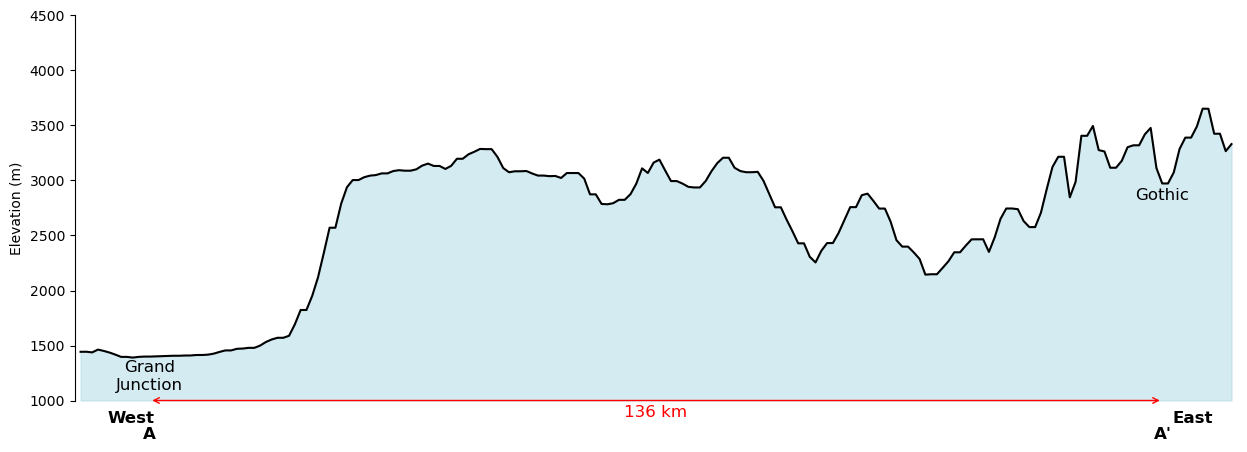

In [4]:
# plot the elevation profile
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(profile.index, profile.values, color='k')

# fill between 1500 and the profile
ax.fill_between(profile.index, 1000, profile.values, color='lightblue', alpha=0.5)

# plot the longitude of gothic and gj
ax.text(gothic.x, elev_gothic-150, "Gothic", fontsize=12, transform=ax.transData, ha='center')
ax.text(gj.x, elev_gj-300, "Grand\nJunction", fontsize=12, transform=ax.transData, ha='center')

# add 'East' and 'West' labels 
ax.text(point_10km_from_gj[0]+0.05, 800, "West", fontsize=12, transform=ax.transData, weight='bold')
ax.text(points_10km_from_gts[0]-.1, 800, "East", fontsize=12, transform=ax.transData, weight='bold')
# underneath add A and A' labels
ax.text(gj.x, 650, "A", fontsize=12, transform=ax.transData, ha='center', weight='bold')
ax.text(gothic.x, 650, "A'", fontsize=12, transform=ax.transData, ha='center', weight='bold')

# add an arrow beteween gj and gothic
ax.annotate('', xy=(gj.x, 1000), xytext=(gothic.x, 1000), arrowprops=dict(arrowstyle='<->', color='red'))
ax.text((gj.x+gothic.x)/2, 850, f'{(distance/1000):.0f} km', 
        fontsize=12, 
        color='red',
        ha='center')
##### formatting the figure ####
# remove x axis labels
ax.set_xticklabels([]);
# remove the x ticks
ax.set_xticks([]);
# axis labels
ax.set_xlabel('');
ax.set_ylabel('Elevation (m)');
ax.set_title('');
# ax.set_title('Elevation Profile from Grand Junction to Gothic, CO');
# axis limits 
ax.set_xlim(point_10km_from_gj[0], points_10km_from_gts[0])
ax.set_ylim(1000,4500)
# remove the x spine
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)